# FEDformer model for Time Series Forecasting

- FEDformer vs Transformer
    - Transformer: 입력 시계열을 그대로 attention에 넣어 모든 시점 간의 관계 학습
    - FEDformer: 입력 시계열을 두 부분으로 분해:
        - Seasonal Part: 반복적이고 주기적인 패턴
        - Trend-Cyclical Part: 장기적인 변화와 느린 흐름
    - Seasonal Part에만 Fourier attention을 적용해 감속, 주기성 예측에 효과적

- FEDformer vs Autoformer
    - 둘 다 시계열을 Seasonal / Trend로 분해
    - Autoformer; 시간 도메인에서 Seasonal Part에 Auto-Correlation Attention 적용
    - FEDformer: 주파수 도메인(Fourier Transform)에서 중요한 주기 성분만 선택 예측
    - 복잡도를 줄여 빠르고 강한 예측 가능
 
- Epoch 30, Loss: 0.0092

### Import libraries

In [1]:
# 기본 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.fft  # Fourier transform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preparing sample time series data

In [2]:
# 1. 시계열 데이터 생성 (sin + noise)
np.random.seed(42)
t = np.arange(0, 500)
data = np.sin(0.05 * t) + 0.1 * np.random.randn(500)
data = data.reshape(-1, 1)

# 2. 정규화 (MinMaxScaler)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 3. 슬라이딩 윈도우 생성 함수
def create_inout_sequences(data, input_window, output_window):
    in_seq, out_seq = [], []
    L = len(data)
    for i in range(L - input_window - output_window):
        train_seq = data[i:i+input_window]
        train_label = data[i+input_window:i+input_window+output_window]
        in_seq.append(train_seq)
        out_seq.append(train_label)
    return np.array(in_seq), np.array(out_seq)

# 4. 윈도우 설정 및 데이터 준비
input_window = 48
output_window = 24
X, y = create_inout_sequences(data_scaled, input_window, output_window)

# 5. 텐서 변환
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)  # (B, input_window, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)  # (B, output_window, 1)

In [3]:
print("Input tensor shape:", X_tensor.shape)
print("Target tensor shape:", y_tensor.shape)

Input tensor shape: torch.Size([428, 48, 1])
Target tensor shape: torch.Size([428, 24, 1])


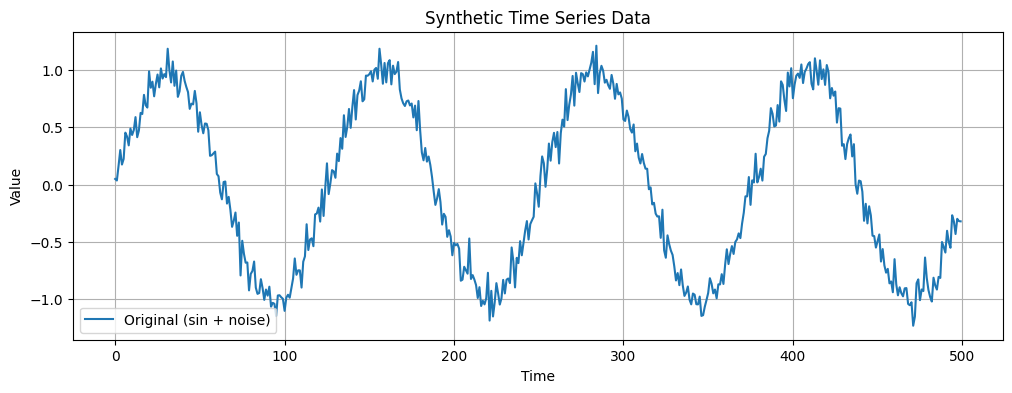

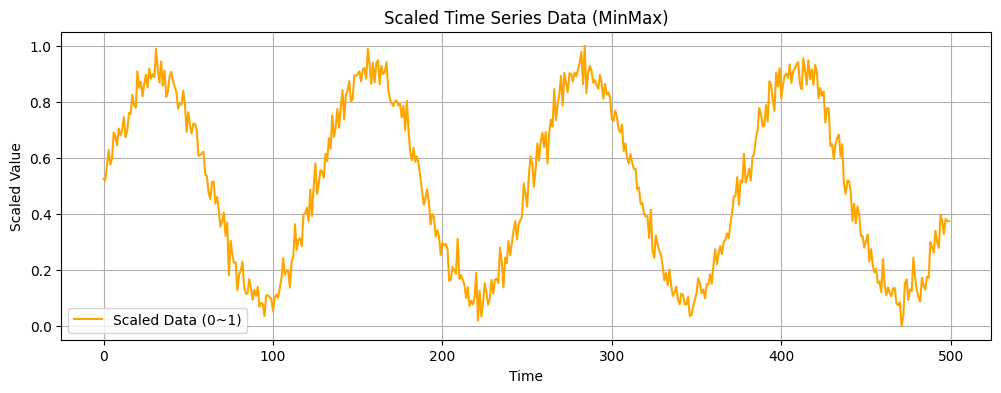

In [4]:
# 시계열 데이터 시각화 (정규화 전 원본)
plt.figure(figsize=(12, 4))
plt.plot(t, data, label="Original (sin + noise)")
plt.title("Synthetic Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# 시계열 데이터 시각화 (MinMaxScaler 적용 후)
plt.figure(figsize=(12, 4))
plt.plot(data_scaled, label="Scaled Data (0~1)", color='orange')
plt.title("Scaled Time Series Data (MinMax)")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()

### SeriesDecomposition

In [5]:
class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.padding = kernel_size // 2
        self.avg_pool = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=self.padding)

    def forward(self, x):
        trend = self.avg_pool(x.transpose(1, 2)).transpose(1, 2)
        seasonal = x - trend
        return seasonal, trend

### FourierBlock

In [6]:
class FourierBlock(nn.Module):
    def __init__(self, mode_select_num, d_model):
        super().__init__()
        self.mode_select_num = mode_select_num
        self.d_model = d_model
        self.projection = nn.Linear(d_model * 2, d_model)

    def forward(self, x):
        B, L, D = x.shape
        x_ft = torch.fft.rfft(x, dim=1)

        freq_energy = torch.abs(x_ft).mean(dim=-1)
        topk_indices = torch.topk(freq_energy, self.mode_select_num, dim=1).indices

        out_real = torch.zeros(B, self.mode_select_num, D, device=x.device)
        out_imag = torch.zeros_like(out_real)

        for b in range(B):
            idx = topk_indices[b]
            out_real[b] = x_ft[b, idx].real
            out_imag[b] = x_ft[b, idx].imag

        x_cat = torch.cat([out_real, out_imag], dim=-1)
        x_proj = self.projection(x_cat)
        return x_proj


### FEDformer

In [7]:
class FEDformer(nn.Module):
    def __init__(self, input_dim, d_model, output_window, mode_select_num=16, kernel_size=25):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.decomp = SeriesDecomposition(kernel_size)
        self.fourier = FourierBlock(mode_select_num, d_model)
        self.decoder = nn.Linear(d_model, output_window)

    def forward(self, x):
        x = self.input_proj(x)                    # (B, L, d_model)
        seasonal, trend = self.decomp(x)          # 분해
        freq_out = self.fourier(seasonal)         # (B, K, d_model)
        freq_summary = freq_out.mean(dim=1)       # (B, d_model)
        out = self.decoder(freq_summary)          # (B, output_window)
        return out.unsqueeze(-1)                  # (B, output_window, 1)

### Hyperparameter Setting and Model Initialization

In [8]:
# 하이퍼파라미터
input_dim = 1
d_model = 64
output_window = 24
learning_rate = 1e-3
num_epochs = 30
batch_size = 32 

# 모델 인스턴스 생성
model = FEDformer(
    input_dim=input_dim,
    d_model=d_model,
    output_window=output_window
    ).to(device)

### Training the Model

In [9]:
# 손실 함수
criterion = nn.MSELoss()  # 또는 nn.L1Loss()

# 옵티마이저
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습용 DataLoader 설정
from torch.utils.data import TensorDataset, DataLoader

# 데이터셋 구성
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 학습 루프
num_epochs = 30

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.1324
Epoch 2, Loss: 0.0264
Epoch 3, Loss: 0.0168
Epoch 4, Loss: 0.0147
Epoch 5, Loss: 0.0135
Epoch 6, Loss: 0.0131
Epoch 7, Loss: 0.0128
Epoch 8, Loss: 0.0116
Epoch 9, Loss: 0.0112
Epoch 10, Loss: 0.0107
Epoch 11, Loss: 0.0101
Epoch 12, Loss: 0.0103
Epoch 13, Loss: 0.0101
Epoch 14, Loss: 0.0092
Epoch 15, Loss: 0.0092
Epoch 16, Loss: 0.0093
Epoch 17, Loss: 0.0090
Epoch 18, Loss: 0.0091
Epoch 19, Loss: 0.0089
Epoch 20, Loss: 0.0089
Epoch 21, Loss: 0.0092
Epoch 22, Loss: 0.0086
Epoch 23, Loss: 0.0087
Epoch 24, Loss: 0.0095
Epoch 25, Loss: 0.0090
Epoch 26, Loss: 0.0087
Epoch 27, Loss: 0.0089
Epoch 28, Loss: 0.0088
Epoch 29, Loss: 0.0087
Epoch 30, Loss: 0.0087


### Prediction -> Post-processing

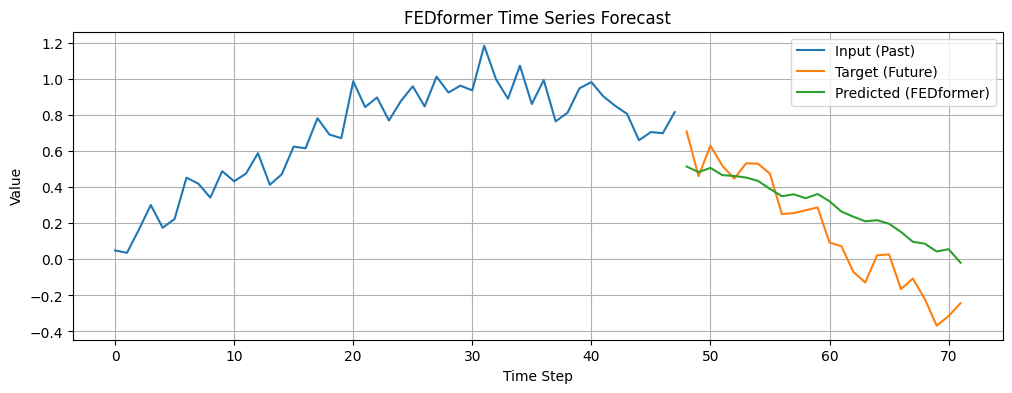

In [12]:
# 평가 모드로 전환 후 하나의 샘플 예측
model.eval()
with torch.no_grad():
    sample_input = X_tensor[0].unsqueeze(0)         # (1, input_window, 1)
    prediction = model(sample_input)                # (1, output_window, 1)

# 차원 정리
predicted = prediction.squeeze().cpu().numpy()      # (output_window,)
actual = y_tensor[0].squeeze().cpu().numpy()        # (output_window,)
input_seq = X_tensor[0].squeeze().cpu().numpy()     # (input_window,)

# 원래 스케일로 역변환
input_original = scaler.inverse_transform(input_seq.reshape(-1, 1)).flatten()
target_original = scaler.inverse_transform(actual.reshape(-1, 1)).flatten()
predicted_original = scaler.inverse_transform(predicted.reshape(-1, 1)).flatten()

# 시각화
x_input = range(input_window)
x_target = range(input_window, input_window + output_window)

plt.figure(figsize=(12, 4))
plt.plot(x_input, input_original, label='Input (Past)')
plt.plot(x_target, target_original, label='Target (Future)')
plt.plot(x_target, predicted_original, label='Predicted (FEDformer)')
plt.title("FEDformer Time Series Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# save and show
plt.savefig("sin_result/FEDformer_sin_function_forecast.png", bbox_inches='tight')
plt.show()

### END